# Vision Transformer (ViT)

## Dataset

In [120]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from tiny_imagenet import TinyImageNet

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = "TINY_IMAGENET"
BS = 256

if DATASET == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BS, shuffle=True)
    train_image_zero, train_target_zero = trainset[0]

elif DATASET == "CIFAR10":
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]
elif DATASET == "TINY_IMAGENET":
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = TinyImageNet(root='./data', split="train",  download=True, transform=train_transform)
    testset =  TinyImageNet(root='./data', split="val", download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

# trainloader.to(device)
# testloader.to(device)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


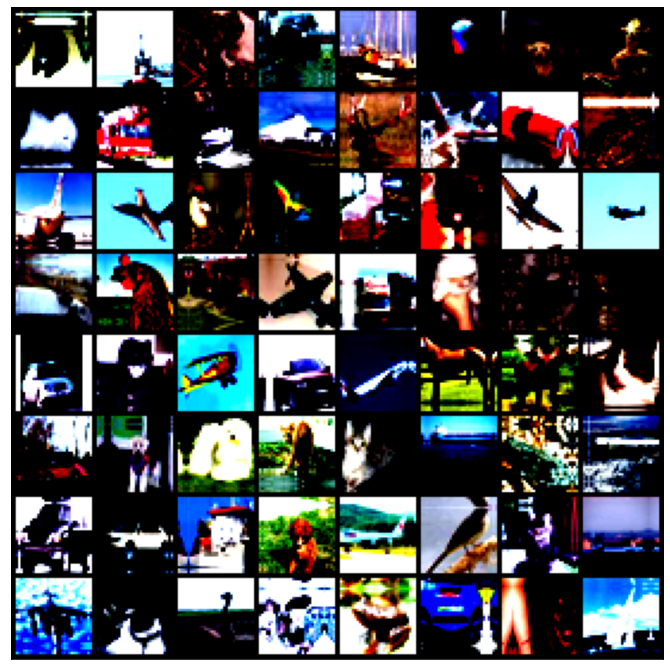

In [121]:
show_batch(trainloader)

## Model

### Model Arch

In [122]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F

def patchify(images, patch_size):
    # B, C, W, H -> B, C * P_W * P_H
    assert len(images.shape) == 4, "Input tensor must have shape (B, C, H, W)"
    B, C, H, W = images.shape
    assert H % patch_size == 0, "Image height must be divisible by patch size"
    assert W % patch_size == 0, "Image width must be divisible by patch size"
    patches = rearrange(
        images,
        "b c (w p1) (h p2) -> b (w h) (p1 p2 c)",
        p1=patch_size,
        p2=patch_size)
    return patches

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        proj_out  = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend  = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if proj_out else nn.Identity()
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, MLP(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
    
class ViT(nn.Module):
    def __init__(
            self,
            patch_emb,
            num_patches,
            n_classes,
            heads=1,
            dim=128,
            dim_head=16,
            emb_dropout=0.,
            depth=1,
            mlp_dim=512,
            debug=False):
        super(ViT, self).__init__()
        
        self.patch_fc    = nn.Linear(patch_emb, dim)
        self.pos_emb     = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.cls_token   = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = TransformerEncoder(
            dim, depth, heads, dim_head, mlp_dim)

        # self.to_latent   = nn.Identity()

        self.mlp_head    = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_classes))
        
    def forward(self, x, debug=False):
        # learned patch embedding
        x = self.patch_fc(x)
        b, n, _ = x.shape
        
        # class token + pos embed
        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        if debug: print("x.shape, self.pos_emb.shape:", x.shape, self.pos_emb.shape)
        x = x + self.pos_emb[:, :(n+1)]
        x = self.emb_dropout(x)

        # transformer
        x = self.transformer(x)
        
        # cls token (can also use mean pooling)
        x = x[:, 0]

        # mlp classifier
        x = self.mlp_head(x)

        return x
    
    def get_params(self):
        o = [param.numel() for param in self.parameters() if param.requires_grad]
        o = sum(o)
        return o

## ViT MNIST

### Train

#### Init Model

In [107]:
IMG_SIZE    = 28
CHANNELS    = 1
N_CLASSES   = 10
PATCH_SIZE  = 7 # 28 // 4
DEBUG       = False
PATCH_EMB   = PATCH_SIZE ** 2 * CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
N_BLOCKS    = 3
NUM_HEADS   = 8
DIM_HEAD    = 64

model = ViT(
    patch_emb=PATCH_EMB,
    n_classes=N_CLASSES,
    num_patches=NUM_PATCHES,
    depth=N_BLOCKS,
    heads=NUM_HEADS,
    dim_head=DIM_HEAD,
    debug=DEBUG).to(device)

test_inp = torch.randint(0, 1, size=(32, CHANNELS, IMG_SIZE, IMG_SIZE)).float().to(device)
test_inp = patchify(test_inp, PATCH_SIZE)
print(test_inp.shape)
pred = model(test_inp, debug=True)
pred.shape, model.get_params()

torch.Size([32, 16, 49])
x.shape, self.pos_emb.shape: torch.Size([32, 17, 128]) torch.Size([1, 17, 128])


(torch.Size([32, 10]), 1193738)

In [108]:
from tqdm.notebook import tqdm

In [109]:
import torch.optim as optim

epochs = 10

MAX_LR       = 1e-3
# MAX_LR       = 1e-2
WEIGHT_DECAY = 1e-4
GRAD_CLIP    = 0.1

optimizer = optim.Adam(
    model.parameters(),
    lr=MAX_LR)
    #,weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=epochs, 
#                                                 steps_per_epoch=len(trainloader))

In [110]:
for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        # if i % 10 == 0:
        #     print(i, len(trainloader))
        images, labels = images.to(device), labels.to(device)
        
        # print(images.shape)
        images = patchify(images, PATCH_SIZE)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()

        loss.backward()

        if GRAD_CLIP:
            nn.utils.clip_grad_value_(model.parameters(), GRAD_CLIP)

        optimizer.step()
        
        # sched.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.39511250932800007


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.12192626351371724


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.08783933160469887


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.07264411719714073


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.05955024112729316


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.05195043626776401


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.04572653166870488


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.03894524122092952


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.036606202551976164


  0%|          | 0/235 [00:00<?, ?it/s]

Training loss: 0.0324386395494196


### Test

In [116]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    # img = images[i].view(1, 784)
    img = images[i]
    img = torch.unsqueeze(img, 0)
    img = patchify(img, PATCH_SIZE)
    # print("img.shape:", img.shape)
    with torch.no_grad():
        logps = model(img.to(device))

    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9818


## ViT CIFAR-10

#### Init Model

In [135]:
IMG_SIZE    = 32
CHANNELS    = 3
N_CLASSES   = 10
PATCH_SIZE  = 8 # 28 // 4
DEBUG       = False
PATCH_EMB   = PATCH_SIZE ** 2 * CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
N_BLOCKS    = 6
NUM_HEADS   = 12
DIM_HEAD    = 32

model = ViT(
    patch_emb=PATCH_EMB,
    n_classes=N_CLASSES,
    num_patches=NUM_PATCHES,
    depth=N_BLOCKS,
    heads=NUM_HEADS,
    dim_head=DIM_HEAD,
    debug=DEBUG).to(device)

test_inp = torch.randint(0, 1, size=(32, CHANNELS, IMG_SIZE, IMG_SIZE)).float().to(device)
test_inp = patchify(test_inp, PATCH_SIZE)
print(test_inp.shape)
pred = model(test_inp, debug=True)
pred.shape, model.get_params()

torch.Size([32, 16, 192])
x.shape, self.pos_emb.shape: torch.Size([32, 17, 128]) torch.Size([1, 17, 128])


(torch.Size([32, 10]), 2002314)

In [136]:
from tqdm.notebook import tqdm

In [140]:
import torch.optim as optim

epochs = 30

MAX_LR       = 1e-3
# MAX_LR       = 1e-2
WEIGHT_DECAY = 1e-4
GRAD_CLIP    = 0.1

optimizer = optim.Adam(
    model.parameters(),
    lr=MAX_LR,
    weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']

sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, MAX_LR, epochs=epochs, 
                                                 steps_per_epoch=len(trainloader))

In [141]:
for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(tqdm(trainloader)):
        # if i % 10 == 0:
        #     print(i, len(trainloader))
        images, labels = images.to(device), labels.to(device)
        
        # print(images.shape)
        images = patchify(images, PATCH_SIZE)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()

        loss.backward()

        if GRAD_CLIP:
            nn.utils.clip_grad_value_(model.parameters(), GRAD_CLIP)

        optimizer.step()
        
        sched.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9836567722413004


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9786126026693656


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9793152912538878


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.00267792325847


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.020673432824563


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.0248096208183133


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.026288617630394


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.0240241949047362


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 1.0065503023108657


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9800952545234135


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.958932160722966


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9312949305286213


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.9004270358353245


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.8845080067308582


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.8571296036243439


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.8264597563111052


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.8063693414537274


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.77885609773957


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.7508696223400078


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.7209715539095353


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.6939671884994117


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.6633024656650971


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.6345662730080741


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.6051717151184471


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.5792044793464699


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.558274543407012


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.5411342092010439


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.5277927695792548


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.5204179390352599


  0%|          | 0/196 [00:00<?, ?it/s]

Training loss: 0.516320928170973


### Test

In [142]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    # img = images[i].view(1, 784)
    img = images[i]
    img = torch.unsqueeze(img, 0)
    img = patchify(img, PATCH_SIZE)
    # print("img.shape:", img.shape)
    with torch.no_grad():
        logps = model(img.to(device))

    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.7525
